In [ ]:
"""
Refine sentiment analysis

1. Polairty throughout the speech
    - focus on VADER and smooth the line plot
    - check polarity by categories
    
2. TextBlob: polarity vs subjectivity

"""

In [18]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

## 1. Load data

In [19]:
# Basic speech_df
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_df_raw = pd.read_pickle('../dump/speech_df')

# Speech + speaker and school info
speech_speaker_cat = pd.read_pickle('../dump/speech_speaker_cat')
speech_speaker_cat = speech_speaker_cat.sort_values(by=['speaker','year']).reset_index(drop=True)
speech_speaker_region = pd.read_pickle('../dump/speech_speaker_region')
speech_speaker_region = speech_speaker_region.sort_values(by=['speaker','year']).reset_index(drop=True)

In [20]:
# speech_speaker_cat.head()

In [21]:
# speech_speaker_region.head()

In [22]:
# Keep the essentials and merge

columns_keep_1 = ['speaker','year','school','transcript','transcript_clean','category','age','age_then','age_cat',]
columns_keep_2 = ['speaker','year','region']

speech_concise = pd.merge(speech_speaker_cat[columns_keep_1],speech_speaker_region[columns_keep_2],\
                         on=['speaker','year'],how='left')

In [23]:
# speech_concise

In [7]:
# # Pickle
# speech_concise.to_pickle('../dump/speech_concise')

## 2. VADER
Valence Aware Dictionary for Sentiment Reasoning

* polarity (positive/negative)
* intensity (strength) of emotion
* coumpound score: sum of all the lexicon ratings

In [24]:
# Instantiate the analyzer
analyzer = SIA()

In [25]:
# Test sentence
analyzer.polarity_scores('The phone is super cool')

{'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}

In [26]:
# Test sentence with punctuation
analyzer.polarity_scores('The phone is super cool!!!')

{'neg': 0.0, 'neu': 0.298, 'pos': 0.702, 'compound': 0.795}

### A. Overall polarity

In [28]:
# Create vader_df

results = []
for i in range(len(speech_df)):
    test = speech_df.transcript.iloc[i]
    ana = analyzer.polarity_scores(test)
    results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

In [29]:
vader_df = pd.DataFrame(results,columns=['neg','neu','pos','compound'])
vader_df

,neg,neu,pos,compound
0,0.088,0.810,0.102,0.9599
1,0.095,0.785,0.120,0.9984
2,0.038,0.821,0.141,0.9995
3,0.072,0.777,0.151,0.9998
4,0.084,0.768,0.148,0.9996
...,...,...,...,...
436,0.069,0.830,0.101,0.9993
437,0.085,0.764,0.151,0.9996
438,0.082,0.749,0.168,0.9998
439,0.079,0.714,0.207,1.0000


In [30]:
# vader_df.neg.mean(),vader_df.neu.mean(),vader_df.pos.mean(),vader_df.compound.mean()

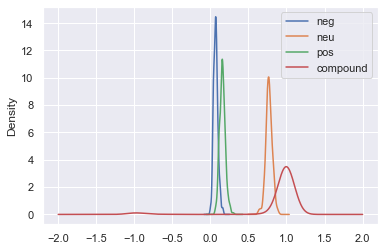

In [31]:
vader_df.plot.kde();
# plt.xlim(-1, 1);

In [32]:
# vader_df.hist();

In [33]:
# Overall, pos has a slightly higher mean than neg. Most (all?) speech transcripts are mostly neutral.

### B. Evolution of polarity in each speech

#### First try with tokenized words (from speech_clean_lemma)

In [34]:
# test = speech_df.transcript.iloc[0]

# # test

# test_words = test.split(" ")

# results_word = []
# for word in test_words:
#     ana = analyzer.polarity_scores(word)
#     results_word.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

# vader_word_df = pd.DataFrame(results_word,columns=['neg','neu','pos','compound'])
# vader_word_df

In [35]:
def simple_plot(y,df,xlabel,ylabel,title):
    plt.plot(df.index,df[y])
    plt.title(title,fontsize=16)
    plt.ylabel(xlabel,fontsize=16)
    plt.xlabel(ylabel,fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

In [37]:
# simple_plot('compound',vader_word_df,'Throughout the speech','Polarity','Polarity throughout a speech (by word)')

In [ ]:
# Too noisy.

#### Analyze sentiment based on sentences (from speech_df; before intense cleaning).

In [38]:
# # Test with the first speech
# test = speech_df_raw.transcript.iloc[0]
# test_sents = test.split(".")
# results_sent = []
# for sent in test_sents:
#     ana = analyzer.polarity_scores(sent)
#     results_sent.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

# vader_sent_df = pd.DataFrame(results_sent,columns=['neg','neu','pos','compound'])
# vader_sent_df

In [39]:
# plt.rcParams.update(plt.rcParamsDefault)
# sns.set()

# simple_plot('compound',vader_sent_df,'Throughout the speech','Polarity','Polarity throughout a speech (by sentence)')

In [ ]:
# Still too noisy to get anything meaningful.

#### Analyze sentiment based on parts (sections).

In [36]:
# Split each speech into 10 parts

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [37]:
def polarity_speech(transcript):
    """
    Input: one transcript (with original punctuation)
    Output: polarity plot throughout the speech
    
    Divide the transript to 10 sections
    
    """
#     sents = transcript.split(".")
    
    sents = split_text(transcript, n=10)

    results = []
    for sent in sents:
        ana = analyzer.polarity_scores(sent)
        results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

    vader_sent_df = pd.DataFrame(results,columns=['neg','neu','pos','compound'])
    
    return simple_plot('compound',vader_sent_df,\
                'Polarity','',\
                title = '')

In [40]:
# # Check the first 30 speeches

# plt.rcParams['figure.figsize'] = [20, 32]

# num_speech = 32
# for i in range(num_speech):
#     test = speech_df_raw.transcript.iloc[i]
#     plt.subplot(num_speech//4,4,i+1)
#     polarity_speech(test)
#     plt.plot(np.arange(0,10), np.zeros(10))
#     plt.title(speech_df_raw.speaker.iloc[i])
    
    
# plt.show()

### Take the average of all transcripts

In [38]:
# Split and analyze all transcripts

all_transcripts = []

for i in range(speech_df_raw.shape[0]):
    transcript = speech_df_raw.transcript.iloc[i]
    sents = split_text(transcript, n=10)
    results = []
    for sent in sents:
        ana = analyzer.polarity_scores(sent)
    #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
        results.append(ana['compound'])
    all_transcripts.append(results)

In [39]:
# Create df
vader_sent_df = pd.DataFrame(all_transcripts,
                             columns=[str(i+1) for i in range(10)]
                            )
vader_sent_df['Transcript'] = [i for i in range(441)]

In [40]:
vader_sent_df

,1,2,3,4,5,6,7,8,9,10,Transcript
0,0.9872,-0.9109,-0.2732,0.2475,0.7713,0.9522,-0.9472,-0.5859,-0.9597,0.9653,0
1,0.9231,-0.0534,0.9784,0.8993,-0.9054,0.8045,0.9674,0.9832,0.9055,0.9757,1
2,0.9452,0.8887,-0.9709,0.9198,-0.9286,0.9188,-0.9122,0.8473,0.9718,0.9795,2
3,0.9774,-0.9613,0.9966,0.9869,0.9453,0.9936,-0.8606,0.6003,-0.1381,0.6217,3
4,0.9517,0.9816,0.9878,0.8885,0.9058,0.8441,0.8627,0.9201,-0.5900,0.9786,4
...,...,...,...,...,...,...,...,...,...,...,...
436,0.9860,0.9595,0.9531,0.9919,0.9978,0.9812,-0.6147,-0.8672,0.9678,0.9840,436
437,0.9864,0.9887,0.9637,0.8347,0.2344,-0.0817,0.8408,0.9563,0.9783,0.9697,437
438,0.9912,0.9195,-0.7096,0.9412,-0.9603,0.9288,-0.8815,0.9682,0.9803,0.9957,438
439,0.9983,0.9981,0.9971,0.9990,0.9996,0.9214,0.9910,0.9477,0.9994,0.9971,439


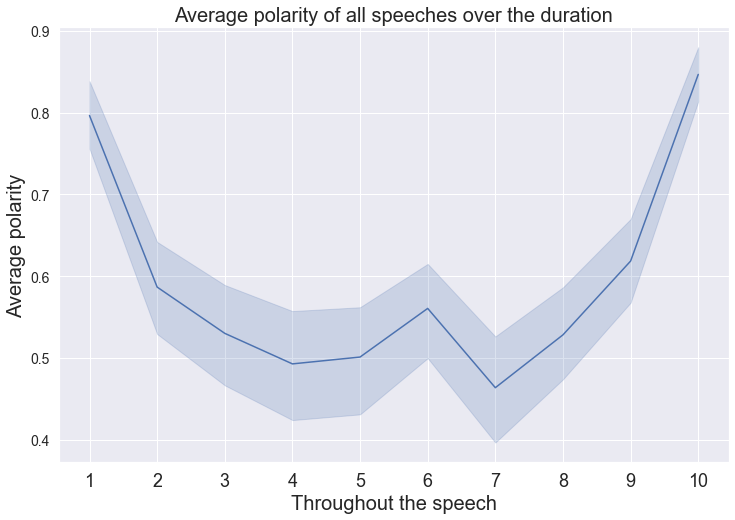

In [41]:
# Melt df (for sns lineplot 95% confidence interval)
vader_sent_melt = pd.melt(vader_sent_df, id_vars='Transcript', value_vars = [str(i+1) for i in range(10)],
#                          val_name = [str(i+1) for i in range(10)]
                         )

# sns lineplot
# plt.rcParams['figure.figsize'] = [12, 8]
fig,ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=vader_sent_melt, x="variable", y="value")
ax.set_title('Average polarity of all speeches over the duration',fontsize=20)
ax.set_ylabel('Average polarity',fontsize=20)
ax.set_xlabel('Throughout the speech',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14);

In [42]:
# vader_sent_melt

In [88]:
def polarity_plot(vader_sent_melt):
    # sns lineplot
#     plt.rcParams['figure.figsize'] = [12, 8]
    sns.lineplot(data=vader_sent_melt, x="variable", y="value")
    plt.title('',fontsize=20)
    plt.ylabel('Average polarity',fontsize=20)
    plt.xlabel('Section of speech',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    
    sns.set_style("white")
    plt.ylim(-.8, 1)
    plt.yticks([-0.8, 0 ,1], labels = ['-0.', '0.0' ,'1.0'], fontsize=14)
    ;

In [89]:
# Try splitting to more sections
def polarity_all(df,num_split):
    # Split and analyze all transcripts
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]

    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_melt = pd.melt(vader_sent_df, id_vars='Transcript', value_vars = [str(i+1) for i in range(num_split)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

#     # sns lineplot
    plt.rcParams['figure.figsize'] = [12, 8]
#     fig,ax = plt.subplots(figsize=(12, 8))
#     sns.lineplot(data=vader_sent_melt, x="variable", y="value")
#     ax.set_title('Average polarity of all speeches over the duration',fontsize=20)
#     ax.set_ylabel('Average polarity',fontsize=20)
#     ax.set_xlabel('Throughout the speech',fontsize=20)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=14);

    return polarity_plot(vader_sent_melt)

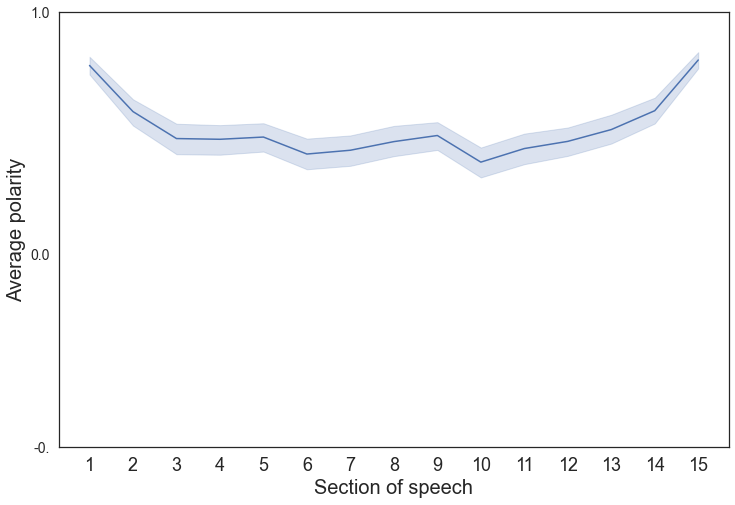

In [90]:
polarity_all(speech_df_raw,15)

In [200]:
# polarity_all(speech_df_raw,20)
# Too noisy

### Check polarity by profession

In [49]:
# speech_concise.head()

In [206]:
# speech_concise['category'].nunique()

10

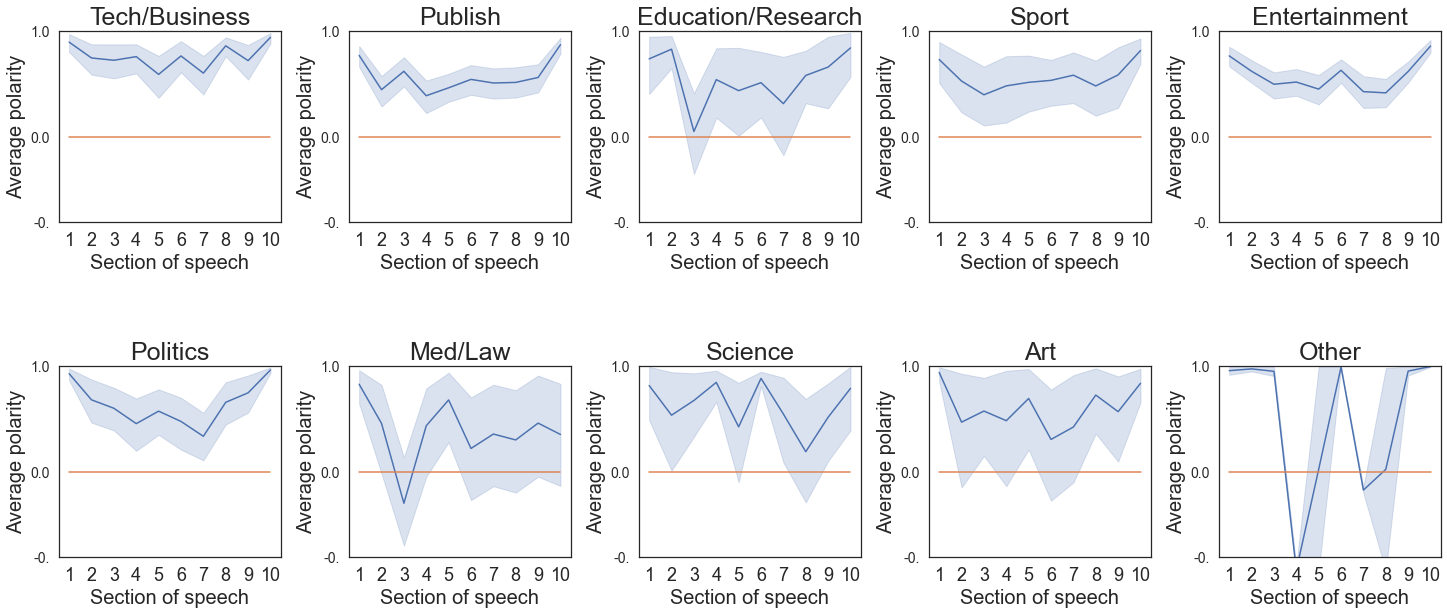

In [91]:
# Check the first 30 speeches

plt.rcParams['figure.figsize'] = [20, 8]

num_plot = 10
categories = speech_concise.category.unique()

figure, axes = plt.subplots(num_plot//5,5)
figure.tight_layout(h_pad=10.0,w_pad=3.0)

for i in range(num_plot):    
    sub_df = speech_concise[speech_concise.category == categories[i]]
    
    plt.subplot(num_plot//5,5,i+1)
    polarity_all(sub_df,10)
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(categories[i], fontdict = {'fontsize' : 25})
    
plt.show()

In [94]:
# function that return the melt df
def polarity_melt(df,num_split):
    # Split and analyze all transcripts
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]

    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_melt = pd.melt(vader_sent_df, id_vars='Transcript', value_vars = [str(i+1) for i in range(num_split)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

    return (vader_sent_melt)

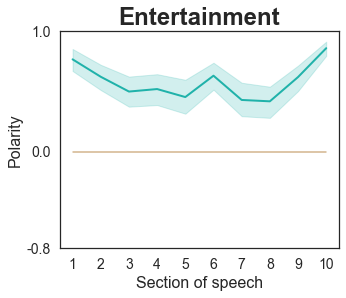

In [148]:
# Entertainment
sub_df = speech_concise[speech_concise.category == "Entertainment"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='lightseagreen',linewidth=2
             )
plt.title('Entertainment',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_entertain.pdf', bbox_inches='tight', transparent = True);

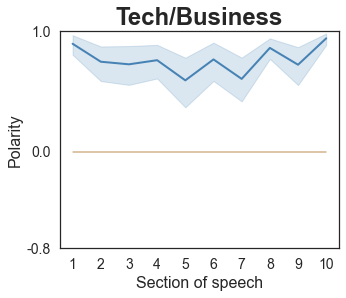

In [147]:
# Tech/business people
# Entertainment
sub_df = speech_concise[speech_concise.category == "Tech/Business"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='steelblue',linewidth=2
             )
plt.title('Tech/Business',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_tech.pdf', bbox_inches='tight', transparent = True);

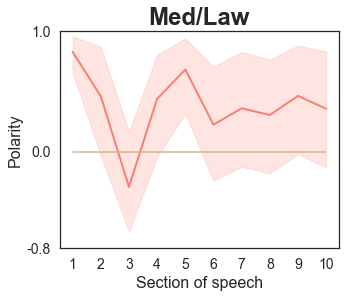

In [154]:
# Med/Law people
sub_df = speech_concise[speech_concise.category == "Med/Law"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='salmon',linewidth=2
             )
plt.title('Med/Law',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_med.pdf', bbox_inches='tight', transparent = True);

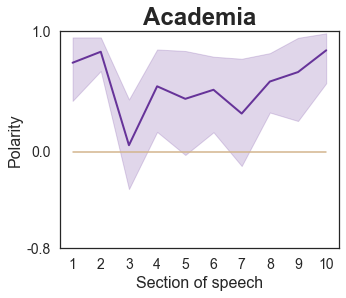

In [150]:
# Academia people
sub_df = speech_concise[speech_concise.category == "Education/Research"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='rebeccapurple',linewidth=2
             )
plt.title('Academia',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_academia.pdf', bbox_inches='tight', transparent = True);

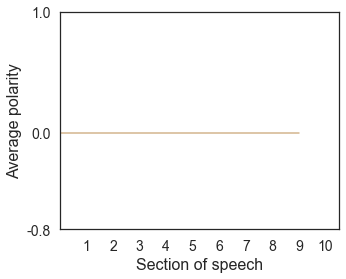

In [142]:
# Empty
sub_df = speech_concise[speech_concise.category == ""]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='rebeccapurple'
             )
plt.title('',fontsize=24,fontweight='bold')
plt.ylabel('Average polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.xlim(0, 10.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10], labels = ['1', '2' ,'3','4','5','6','7','8','9','10'], fontsize=14)
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_frame.pdf', bbox_inches='tight', transparent = True);

In [92]:
# speech_concise[speech_concise.category == "Tech/Business"]

### Smooth the line

In [192]:
# Smooth the line
from scipy.interpolate import interp1d

# Original
x = np.linspace(1, 15, num=16, endpoint=True)
y = vader_sent_df.iloc[0].values

# Interpolation
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

# Plot
xnew = np.linspace(1, 15, num=100, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

ValueError: x and y arrays must be equal in length along interpolation axis.

In [194]:
# Different sns themes

sns.set_style("white")
# sns.set_style("darkgrid")
# sns.set_style("dark")

In [189]:
num_interp = 100
num_split = 10


def smooth_polarity(vader_sent_df, num_split, num_interp):
    
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]
    
    
    x = np.linspace(1, num_split, num=num_split, endpoint=True)
    xnew = np.linspace(1, num_split, num=num_interp, endpoint=True)

    y_new_list = []
    for i in range(vader_sent_df.shape[0]):    
        y = vader_sent_df.iloc[i,:-1].values

        # Interpolation
        f2 = interp1d(x, y, kind='cubic')
        y_new_list.append(f2(xnew))


    # Create df
    vader_sent_df_interp = pd.DataFrame(y_new_list,columns=[str(i+1) for i in range(num_interp)])
    vader_sent_df_interp['Transcript'] = [i for i in range(441)]


    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_interp_melt = pd.melt(vader_sent_df_interp, id_vars='Transcript',\
                                     value_vars = [str(i+1) for i in range(num_interp)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

    # sns lineplot
    # plt.rcParams['figure.figsize'] = [12, 8]
    fig,ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=vader_sent_interp_melt, x="variable", y="value")
    
    ax.grid(False)
    ax.axes.xaxis.set_ticks([])
    ax.set_title('Average polarity of all speeches over the duration',fontsize=20)
    ax.set_ylabel('Average polarity',fontsize=20)
    ax.set_xlabel('Throughout the speech',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14);

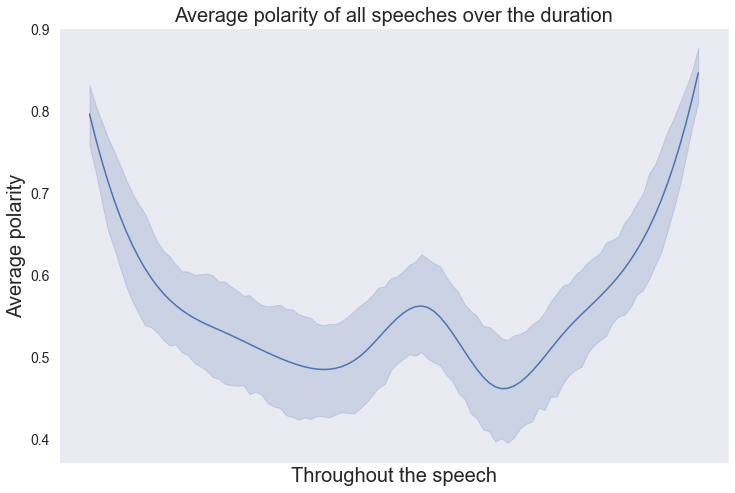

In [190]:
smooth_polarity(vader_sent_df, num_split=10, num_interp=100)

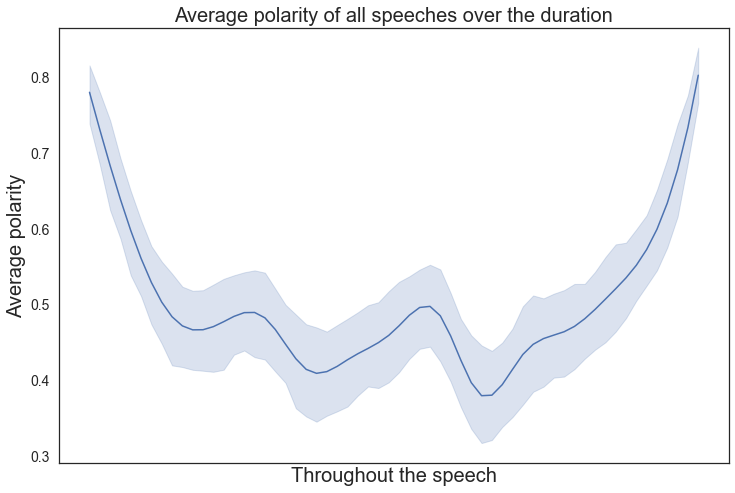

In [199]:
smooth_polarity(vader_sent_df, num_split=15, num_interp=60)

## 3. TextBlob
(Following Alice Zhao's tutorial).

### A. Overall analysis (polarity, subjectivity)

In [34]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

speech_df_raw['polarity'] = speech_df_raw['transcript'].apply(pol)
speech_df_raw['subjectivity'] = speech_df_raw['transcript'].apply(sub)
speech_df_raw

,speaker,year,school,transcript,length,polarity,subjectivity
0,SIDDHARTHA MUKHERJEE,2018,Univ. of Southern California,I wish someone had told me at my own commenc...,14487,0.113403,0.453817
1,JESMYN WARD,2018,Tulane University,Persist. Be patient. Be well. Good morning....,14063,0.105514,0.506782
2,DAVID SEDARIS,2018,OBERLIN COLLEGE,"Thank you so much for having me, and for prese...",10587,0.113144,0.476305
3,NIGHT SHYAMALAN,2018,DREXEL UNIVERSITY,\nwhat's up dragons alright let's start\n\nwit...,26406,0.071645,0.478227
4,TERRY TEACHOUT,2018,HAMILTON HOLT SCHOOL,"I’m supposed to keep it short, and I approve o...",6288,0.209266,0.475779
...,...,...,...,...,...,...,...
436,WILLIAM ALLEN,1936,WHITE NORTHWESTERN UNIVERSITY,About all that a commencement orator can do fo...,14953,0.181468,0.484450
437,FRANKLIN D ROOSEVELT,1932,OGLETHORPE UNIVERSITY,"For me, as for you, this is a day of honorable...",16017,0.115993,0.458075
438,OPRAH WINFREY,1918,USC,Thank you Wallis Annenberg and a special thank...,15301,0.127203,0.493960
439,RALPH WALDO,1838,EMERSON HARVARD UNIVERSITY,"In this refulgent summer, it has been a luxury...",40403,0.157895,0.523631


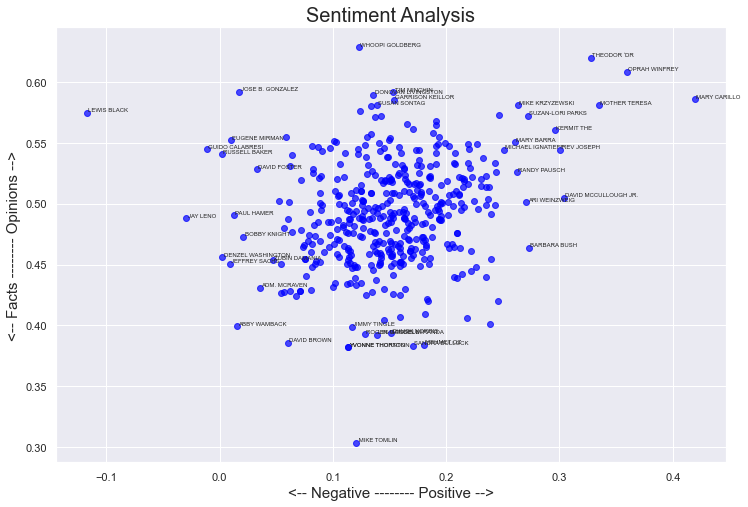

In [35]:
# Let's plot the results

plt.rcParams['figure.figsize'] = [12, 8]

for index, speech in enumerate(speech_df_raw.index):
    x = speech_df_raw.polarity.loc[speech]
    y = speech_df_raw.subjectivity.loc[speech]
    plt.scatter(x, y, color='blue',alpha=0.7)
    
    if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
        plt.text(x+.001, y+.001, speech_df_raw['speaker'][index], fontsize=6)
    
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# plt.xlim(-.01, .45)

plt.show()

### Add in school info
Color the points based on location of school

In [136]:
speech_speaker_region = pd.read_pickle('../dump/speech_speaker_region')
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

speech_speaker_region['polarity'] = speech_speaker_region['transcript'].apply(pol)
speech_speaker_region['subjectivity'] = speech_speaker_region['transcript'].apply(sub)

In [145]:
speech_speaker_region.shape

(331, 16)

In [100]:
# # Let's plot the results

# # Color the nodes based on region
# regions = speech_speaker_region.region.tolist()
# mapping = {region:i for i,region in enumerate(set(regions))}
# node_label = [mapping[regions[n]] for n in range(len(regions))]
# colormap = np.array(['r', 'g', 'b'])

# plt.rcParams['figure.figsize'] = [12, 8]
# plt.scatter(speech_speaker_region.polarity, y=speech_speaker_region.subjectivity,
#             c = colormap[node_label], alpha=0.7)

# # Label outliers
# for index in speech_speaker_region.index:
#     x = speech_speaker_region.polarity.iloc[index]
#     y = speech_speaker_region.subjectivity.iloc[index]
#     if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
#         plt.text(x+.001, y+.001, speech_speaker_region['speaker'][index], fontsize=6)
        
# # plt.legend(labels=['East','West','Central'])    
# plt.title('Sentiment Analysis', fontsize=20)
# plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
# plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# # plt.xlim(-.01, .45)

# plt.show()

<ipython-input-138-580df3742ba9>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


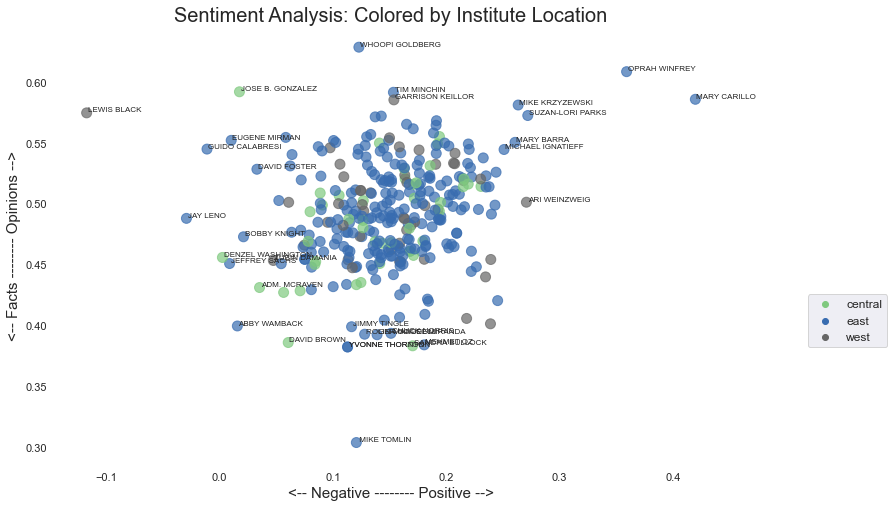

In [138]:
# Color the nodes based on school region
category = 'region'
categories = speech_speaker_region[category].tolist()
types = sorted(set(categories))
mapping = {region:i for i,region in enumerate(types)}
node_label = [mapping[categories[n]] for n in range(len(categories))]

cmap = plt.get_cmap('Accent')
maxval = np.max(node_label) 

plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(speech_speaker_region.polarity, y=speech_speaker_region.subjectivity,
            c = [cmap(v/maxval) for v in node_label], alpha=0.7, s=100)

# Label outliers
for index in speech_speaker_region.index:
    x = speech_speaker_region.polarity.iloc[index]
    y = speech_speaker_region.subjectivity.iloc[index]
    if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
        plt.text(x+.001, y+.001, speech_speaker_region['speaker'][index], fontsize=8)
        
# plt.legend(labels=['East','West','Central'])    
plt.title('Sentiment Analysis: Colored by Institute Location', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# plt.xlim(-.01, .45)

# Includ legend
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=1, prop={'size': 12},bbox_to_anchor=(1.25, 0.4));

ax = plt.axes() 
ax.set_facecolor("white") 

plt.show()

### Add speaker info (category of profession, age)

In [66]:
speech_speaker_cat = pd.read_pickle('../dump/speech_speaker_cat')

In [148]:
speech_speaker_cat = speech_speaker_cat.sort_values(by=['speaker','year']).reset_index(drop=True)
speech_speaker_region = speech_speaker_region.sort_values(by=['speaker','year']).reset_index(drop=True)

In [149]:
speech_speaker_region[speech_speaker_region.speaker == "OPRAH WINFREY"]

,speaker,profession,born,age,origin,category,year,school,transcript,length,age_then,latitude,longitude,region,polarity,subjectivity
250,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2007,HOWARD UNIVERSITY,"President Swygert, trustees, distinguished gue...",14168,54,38.919700,-77.018700,east,0.167572,0.509614
251,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2017,Agnes Scott College,You're nothing if you are not the truth. Ex...,1264,64,33.768506,-84.294535,east,0.359211,0.608333
252,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2018,USC,Thank you Wallis Annenberg and a special thank...,15301,65,34.020500,-118.285600,west,0.127203,0.493960


In [150]:
speech_speaker_cat[speech_speaker_cat.speaker == "OPRAH WINFREY"]

,speaker,profession,born,age,origin,category,year,school,transcript,length,age_then,transcript_clean,age_cat
250,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2007,HOWARD UNIVERSITY,"President Swygert, trustees, distinguished gue...",14168,54,"President Swygert, trustees, distinguished gue...",50-60
251,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2017,Agnes Scott College,You're nothing if you are not the truth. Ex...,1264,64,You're truth. Excerpts\r\n\r\n\r\n\r\n\r\n ...,60-70
252,OPRAH WINFREY,American host,1953,67,Kosciusko MS,Entertainment,2018,USC,Thank you Wallis Annenberg and a special thank...,15301,65,Thank Wallis Annenberg special thank Dean Will...,60-70


In [68]:
len([cmap(v/maxval) for v in node_label])

331

In [124]:
categories[22]

'Entertainment'

In [127]:
node_label[22]

2

In [128]:
mapping

{'Art': 0,
 'Education/Research': 1,
 'Entertainment': 2,
 'Med/Law': 3,
 'Other': 4,
 'Politics': 5,
 'Publish': 6,
 'Science': 7,
 'Sport': 8,
 'Tech/Business': 9}

In [131]:
set(node_label)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [132]:
types

['Art',
 'Education/Research',
 'Entertainment',
 'Med/Law',
 'Other',
 'Politics',
 'Publish',
 'Science',
 'Sport',
 'Tech/Business']

In [133]:
mapping

{'Art': 0,
 'Education/Research': 1,
 'Entertainment': 2,
 'Med/Law': 3,
 'Other': 4,
 'Politics': 5,
 'Publish': 6,
 'Science': 7,
 'Sport': 8,
 'Tech/Business': 9}

<ipython-input-155-662b170ddd4c>:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


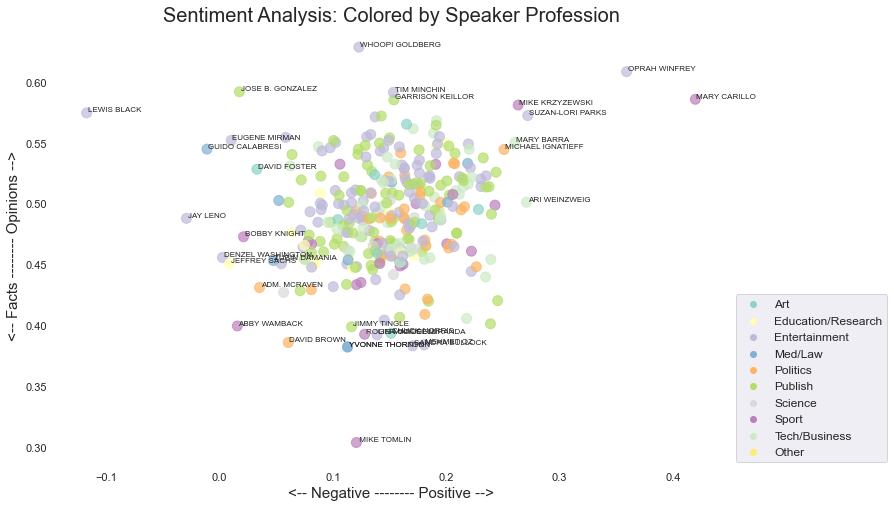

In [155]:
# Color the nodes based on speaker profession
category = 'category'
categories = speech_speaker_cat[category].tolist()
types = sorted(set(categories))
types = ['Art',
 'Education/Research',
 'Entertainment',
 'Med/Law',
 'Politics',
 'Publish',
 'Science',
 'Sport',
 'Tech/Business',
 'Other']
mapping = {region:i for i,region in enumerate(types)}
node_label = [mapping[categories[n]] for n in range(len(categories))]

cmap = plt.get_cmap('Set3')
maxval = np.max(node_label) 

plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(speech_speaker_region.polarity, y=speech_speaker_region.subjectivity,
            c = [cmap(v/maxval) for v in node_label], alpha=0.7, s=100)

# Label outliers
for index in speech_speaker_region.index:
    x = speech_speaker_region.polarity.iloc[index]
    y = speech_speaker_region.subjectivity.iloc[index]
    if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
        plt.text(x+.001, y+.001, speech_speaker_region['speaker'][index], fontsize=8)
        
# plt.legend(labels=['East','West','Central'])    
plt.title('Sentiment Analysis: Colored by Speaker Profession', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# plt.xlim(-.01, .45)

# Includ legend
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=1, prop={'size': 12},bbox_to_anchor=(1.25, 0.4));

ax = plt.axes() 
ax.set_facecolor("white") 

plt.show()

<ipython-input-156-3516bf70b03e>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


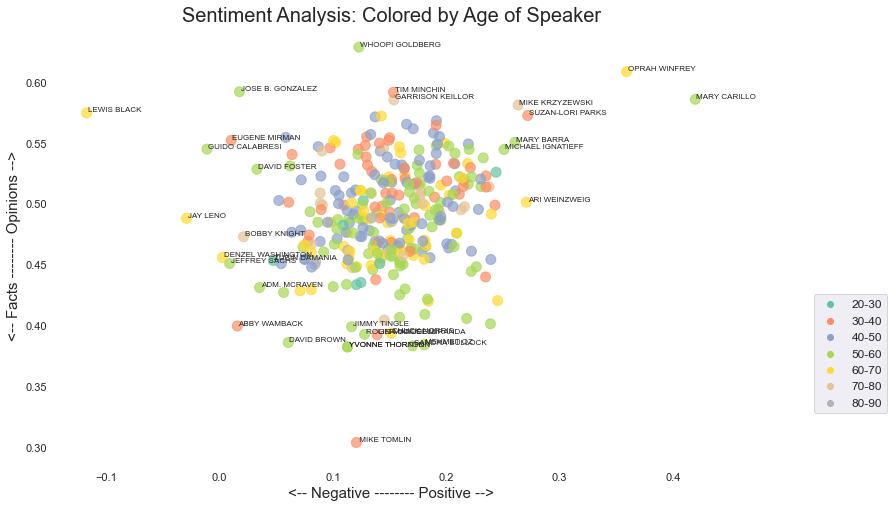

In [156]:
# Color the nodes based on speaker profession
category = 'age_cat'
categories = speech_speaker_cat[category].tolist()
types = sorted(set(categories))
mapping = {region:i for i,region in enumerate(types)}
node_label = [mapping[categories[n]] for n in range(len(categories))]

cmap = plt.get_cmap('Set2')
maxval = np.max(node_label) 

plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(speech_speaker_region.polarity, y=speech_speaker_region.subjectivity,
            c = [cmap(v/maxval) for v in node_label], alpha=0.7, s=100)

# Label outliers
for index in speech_speaker_region.index:
    x = speech_speaker_region.polarity.iloc[index]
    y = speech_speaker_region.subjectivity.iloc[index]
    if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
        plt.text(x+.001, y+.001, speech_speaker_region['speaker'][index], fontsize=8)
        
# plt.legend(labels=['East','West','Central'])    
plt.title('Sentiment Analysis: Colored by Age of Speaker', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# plt.xlim(-.01, .45)

# Includ legend
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=1, prop={'size': 12},bbox_to_anchor=(1.25, 0.4));

ax = plt.axes() 
ax.set_facecolor("white") 

plt.show()

### B. Sentiment in each speech

In [177]:
# Split each routine into 10 parts
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [230]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
data = speech_df_raw
for t in data.transcript:
    split = split_text(t,10)
    list_pieces.append(split)

# 441 elements (speeches) in list_pieces
# Each element (speech) has 10 elements (sections)
len(list_pieces), len(list_pieces[0])

(441, 10)

In [231]:
# Calculate the polarity for each piece of text

polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)

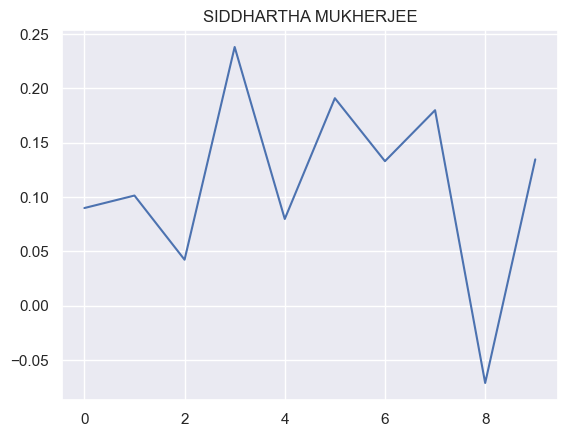

In [235]:
# Show the plot for one comedian
plt.rcParams.update(plt.rcParamsDefault)
sns.set()
plt.plot(polarity_transcript[0])
plt.title(data['speaker'].iloc[0])
plt.show()

In [233]:
# data

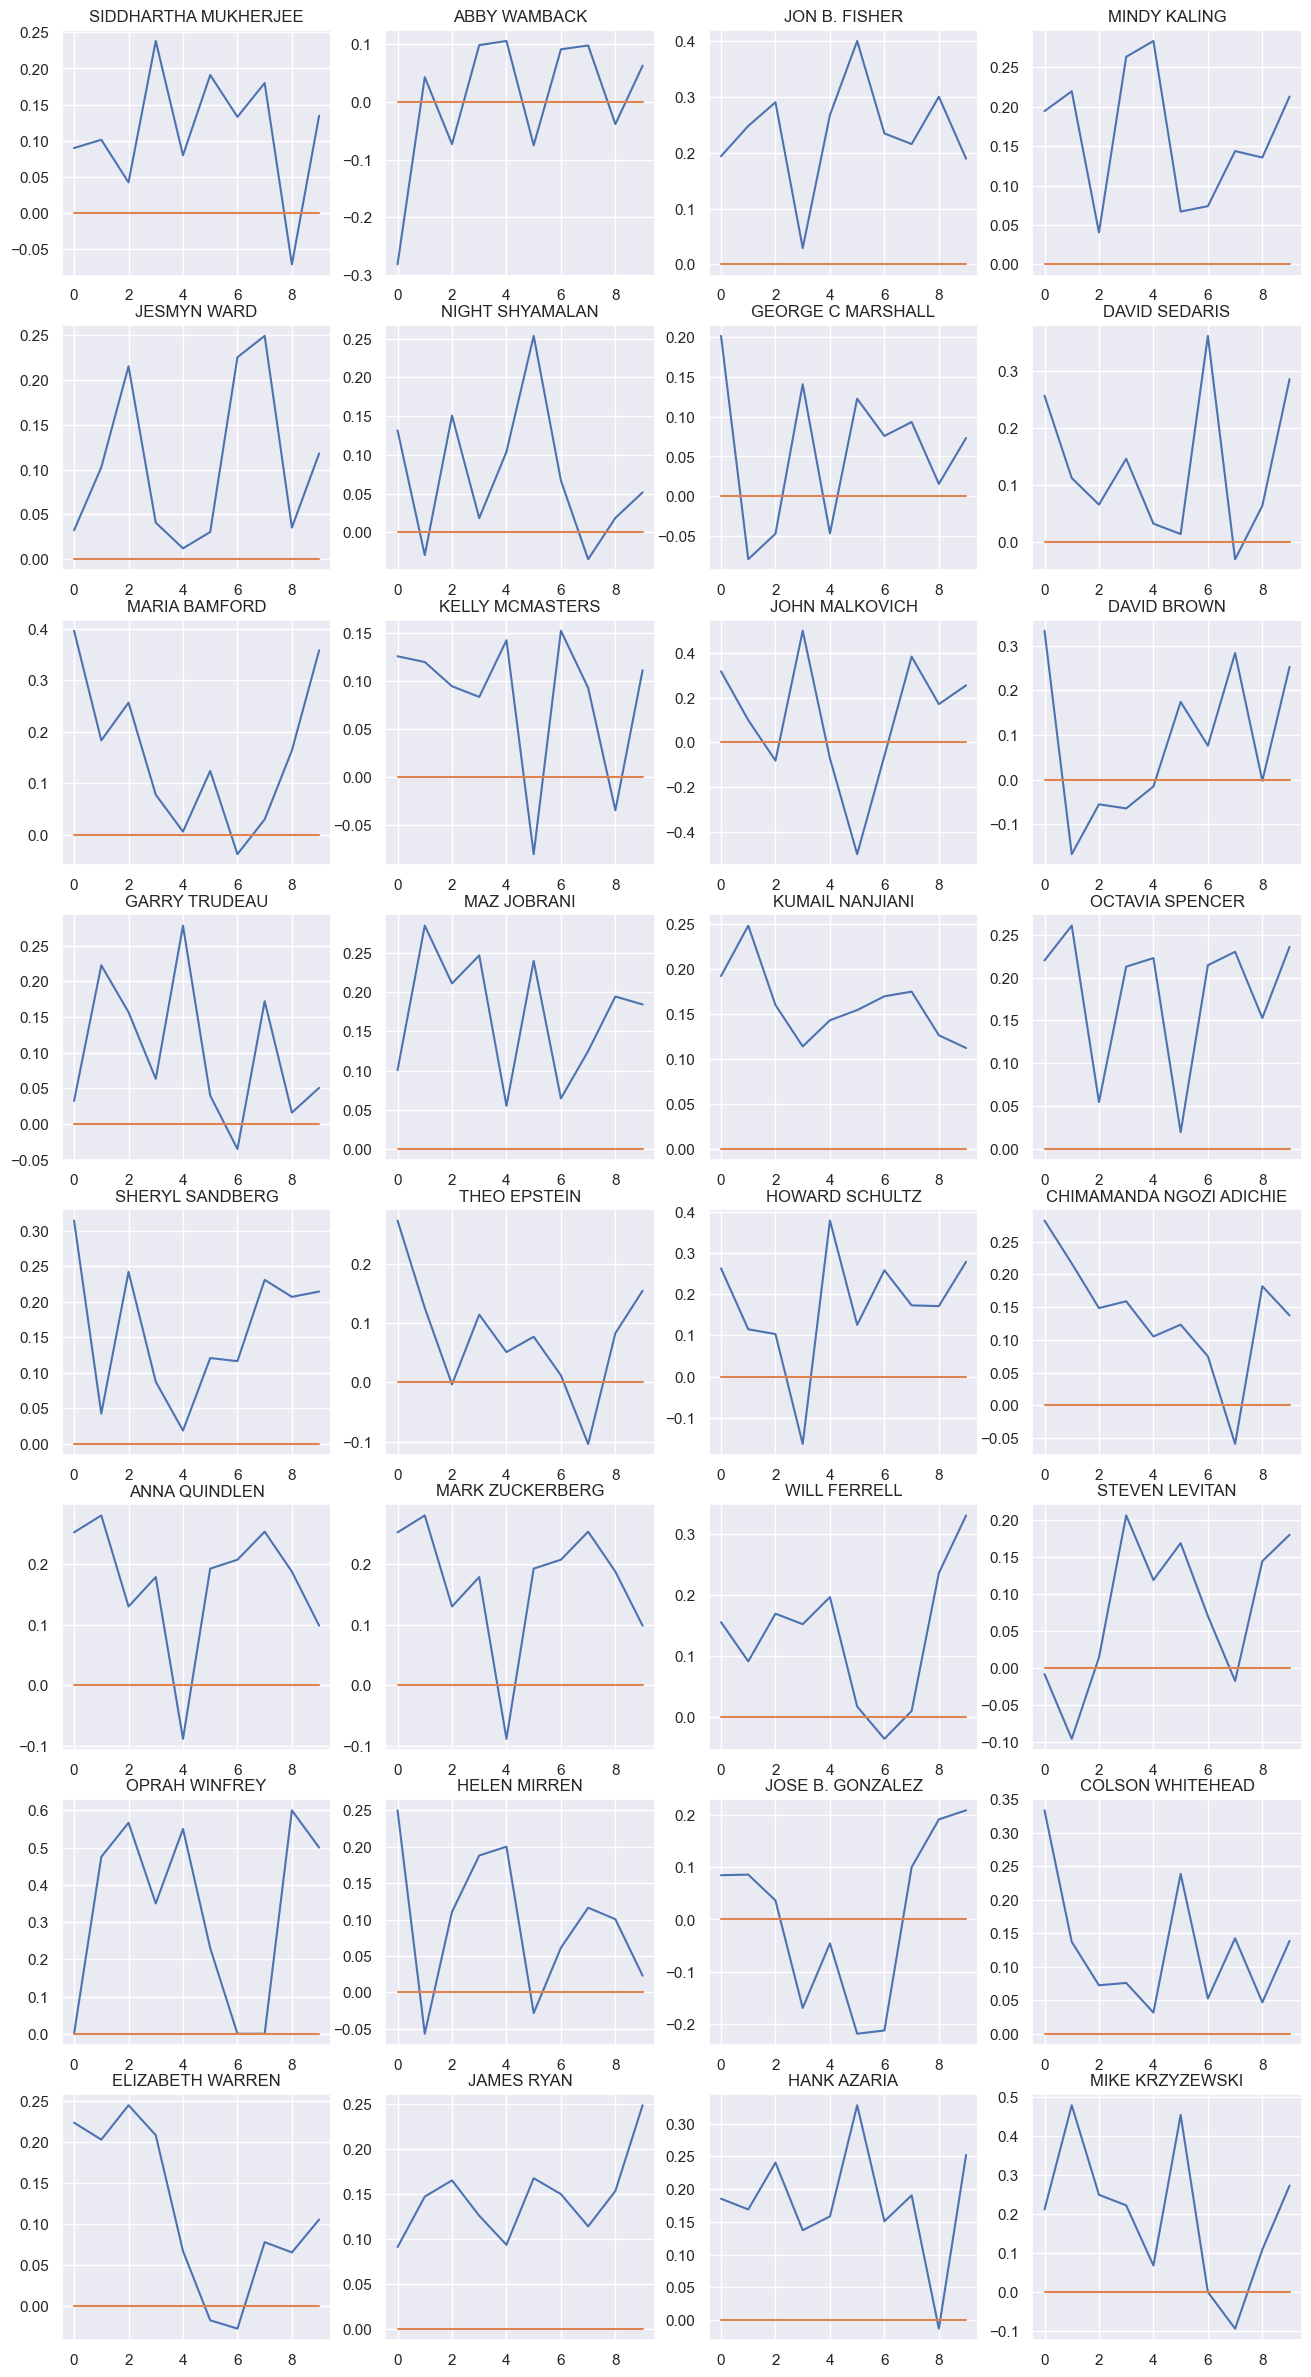

In [234]:
# Show the plot for all speeches
plt.rcParams['figure.figsize'] = [16, 30]

num_speech=32
for index, speech in enumerate(data.iloc[:num_speech].index):    
    plt.subplot(num_speech//4, 4, index+1)
    plt.plot(polarity_transcript[index])
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(data['speaker'][index])
#     plt.ylim(ymin=-.5, ymax=.5)
    
plt.show()

In [ ]:
# Comparison of VADER and TextBlob:
# Looks like 'compound' of VADER shows a more consistent trend among all speeches, which is,
# high opening and ending, with one or two dips in the middle.